<a href="https://colab.research.google.com/github/seungmindavid/Representational_Learning/blob/main/cVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Conditionalization
a) Derive the standard $\log(p(x)$ bound (the ELBO) loss function, but for the conditional model in figure b, i.e. derive the same bound for $\log p(x|c)$

- Original (without c) $\log p(x)$ bound:
$L(p(x|z), q(z|x)) = \mathbb{E}_{q(z|x)}[MSE(x, p(x|z))]+KL[q(z|x) || N(0,I)]$

$\longrightarrow -\log p(x) = -\log p(x|z) + KL[q(z|x) || N(0,I)]$, where
$KL[q(z|x) || N(0,I)] = 0.5(-\log \frac{\Sigma_p}{\Sigma_q} -k + tr\Sigma^{-1}_p \Sigma_q + (\mu_2 - \mu_1)^T\Sigma^{-1}_p(\mu_2-\mu_1))$

Then, $L(p(x|c,z), q(z|x)) = -\log p(x|c,z) + KL[q(z|x) || N(0,I)]$.

And $\text{KL}[q(z|x)||p(x)]$ (Regularizer) : $q(z|x)$ doesn't rely on c value and p(x) also not since $p(x) = N(0,I)$.

$
\text{KL}[q(z|x)||p(x)] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$

$= -\log p(x|c,z) + 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)$

b) Implement this conditional model in PTorch. Using the MNIST dataset, train your model with the digit label as the c condition. I used k=2.

(Question 1.c to 3.e are below the code section)

- I think about 2 options for using c (label) information.

1) One hot encoding

2) Normalize version

I used Normalize version since I believe one hot encoding increase lots of dimension with lots of unnecessary spaces. i.e., $(7 \rightarrow [0,0,0,0,0,0,0,1,0,0])$.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision
import pathlib

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


# Loading Dataset (MNIST)

Batch size for training dataset: 1024
Batch size for test dataset: 10


In [2]:
batch_size_train = 1024
batch_size_test = 10

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x*255)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download = True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size= batch_size_test, shuffle=False
)


100%|██████████| 9912422/9912422 [00:00<00:00, 110722114.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112579641.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53706901.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21357095.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Loss Construction (EBLO)

$\log p(x) \geq \log p(x|z) - KL[q(z|x)||p(x)]$

And we want minimal loss (convert $+ \rightarrow -$)


$L = -\log p(x) = \log p(x|c,z) + KL[q(z|x)||p(x)]$

$-\log p(x|c,z)$ : MSE is built in Pytorch

$\text{KL}[q(z|x)||p(x)]$ (Regularizer) : $q(z|x)$ doesn't rely on c value and p(x) also not since $p(x) = N(0,I)$.

$
\text{KL}[q(z|x)||p(x)] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$

In [3]:
def KL_div_N01(z_mu, z_log_sigma_sq):
  term_1 = z_log_sigma_sq.sum(axis=1) # trace log Sigma q
  term_2 = z_log_sigma_sq.exp().sum(axis=1) # trace Sigma q
  term_3 = (z_mu*z_mu).sum(axis=1) # this is mu_q squared and summed
  return 0.5*(-term_1 + term_2 + term_3 - z_mu.shape[1]).mean()

In [4]:
def NormalizeTensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))

# Build VAE(Without using c-label values): Using class material

$x^{(i)} \in \mathbb{R}^{784}$,
$z^{(i)} \in \mathbb{R}^{2}$


And I will construct 3 layers for each encoder and decoder.

Encoder: 784 neurons -> 512 neurons -> 2 neurons

Decoder: 2 neurons -> 512 neurons -> 784 neurons

In [5]:

##
## fully connected
##
class VAE( nn.Module ):
    def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
        super(VAE, self).__init__()

        self.enc = nn.ModuleList()
        self.dec = nn.ModuleList()
        self.n_z = n_z

        for i in range(n_layers+1):
            if i == 0: #first layers
                self.enc.append(nn.Linear(n_input, layer_size))
                self.dec.append(nn.Linear(n_z, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())
            elif i == n_layers: #last layers
                self.enc.append(nn.Linear(layer_size, 2*n_z)) # we need this for enc's mu and sigma
                self.dec.append(nn.Linear(layer_size, n_output))
            else:
                self.enc.append(nn.Linear(layer_size, layer_size))
                self.dec.append(nn.Linear(layer_size, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())

        self.enc = nn.Sequential(*self.enc)
        self.dec = nn.Sequential(*self.dec)


    def enc_to_mean_lss(self,x):
        enc_output = self.enc(x)
        mean = enc_output[...,:self.n_z]
        log_sigma_sq = enc_output[...,self.n_z:]
        return mean, log_sigma_sq

    def forward(self, x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)

        sigma = log_sigma_sq.exp().sqrt()
        z = mean + torch.randn_like(mean)*sigma
        output = self.dec(z)

        return output

    def forward_train(self, x):

        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        #print(mean.shape)
        z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
        output = self.dec(z)

        return output, mean, log_sigma_sq

    def encode_mean(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        return mean

    def encode(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        sigma = self.enc_log_sigma_sq.exp().sqrt()
        return mean + torch.randn_like(mean)*sigma

    def decode(self,z):
        return self.dec(z)



# Build cVAE in Pytorch (VAE with c-label values)

$x^{(i)} \in \mathbb{R}^{784}$,
$z^{(i)} \in \mathbb{R}^{2}$,
$c^{(i)} \in \mathbb{R} \rightarrow c^{(i)} \in \mathbb{R}^{1}$ by one-hot encoding


And I will construct 3 layers for each encoder and decoder.

Encoder: 784 neurons -> 512 neurons -> 2 neurons

Decoder: 3 neurons ($P(x|c,z)$) -> 512 neurons -> 784 neurons



In [6]:
class cVAE(nn.Module):
  def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
    super(cVAE, self).__init__()

    self.enc = nn.ModuleList()
    self.dec = nn.ModuleList()
    self.n_z = n_z

    for i in range(n_layers+1):
      if i == 0: #first layer: we put first input (x) into hidden layer
        self.enc.append(nn.Linear(n_input, layer_size))
        self.dec.append(nn.Linear(n_z+1, layer_size))
        self.enc.append(nn.ReLU())
        self.dec.append(nn.ReLU())
      elif i == n_layers:
        self.enc.append(nn.Linear(layer_size, 2*n_z)) # 2*n_z is because we need mu and sigma
        self.dec.append(nn.Linear(layer_size, n_output))
      else:
        self.enc.append(nn.Linear(layer_size, layer_size))
        self.dec.append(nn.Linear(layer_size, layer_size))
        self.enc.append(nn.ReLU())
        self.dec.append(nn.ReLU())

    self.enc = nn.Sequential(*self.enc)
    self.dec = nn.Sequential(*self.dec)

  def enc_to_mean_lss(self,x):
    enc_output = self.enc(x)
    #print("shape of enc_output is")
    #print(enc_output.shape)
    mean = enc_output[...,:self.n_z]
    log_sigma_sq = enc_output[...,self.n_z:]
    return mean, log_sigma_sq

  def forward(self, x, c):
    mean, log_sigma_sq = self.enc_to_mean_lss(x)
    z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
    #c = F.one_hot(c)
    c = NormalizeTensor(c)
    c = c.view(c.shape[0],1)
    z_c = torch.cat([z,c], dim=1)
    #print("mean shape")
    #print(m.shape)
    #print("z shape ")
    #print(z.shape)
    output = self.dec(z_c)
    return output, mean, log_sigma_sq

  def encode_mean(self,x):
    m, s = self.enc_to_mean_lss(x)
    return m

  def encode(self,x):
    mean, log_sigma_sq = self.enc_to_mean_lss(x)
    sigma = self.enc_log_sigma_sq.exp().sqrt()
    return mean + torch.randn_like(mean)*sigma

  def decode(self, z, c, i):
    #c = F.one_hot(c)
    c = NormalizeTensor(c)[i]
    c = c.resize_(1,1)
    z_c = torch.cat([z,c], dim=1)
    return self.dec(z_c)



# Training cVAE

In [7]:
input_size = 28**2
n_z = 2 # z
n_layers = 3
layer_size = 512

cvae_KL_Loss = []
cvae_MSE_Loss = []

saved_params_path = "./saved_params_cvae"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# want 50 epochs
n_epochs = 50

cvae_instance = cVAE(n_input = input_size, n_output= input_size, n_z = n_z, n_layers= n_layers, layer_size = layer_size)

mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01
optimizer = torch.optim.Adam(cvae_instance.parameters(), lr=3e-4)

for epoch in range(n_epochs):
  running_loss = 0.0
  running_kl_loss = 0.0
  running_mse_loss = 0.0
  running_n = 0

  for i, data in enumerate(train_loader, 0):
    # input : image
    # label : label to image
    inputs, labels = data

    images_in = inputs.view(inputs.shape[0], -1).clone().detach()

    optimizer.zero_grad()
    x_hat, mean, log_sigma_sq = cvae_instance.forward(images_in, labels)

    mse_loss = mse_loss_func(x_hat, images_in)
    kl_div_loss = kl_loss_func(mean, log_sigma_sq)
    loss = mse_loss + kl_div_loss
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_kl_loss += kl_div_loss.item()
    running_mse_loss += mse_loss.item()
    running_n += inputs.shape[0]

  print(
      f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
      f'KL loss: {running_kl_loss / running_n:.6f}',
      f'MSE loss: {running_mse_loss / running_n:.6f}')

  cvae_KL_Loss.append(running_kl_loss / running_n)
  cvae_MSE_Loss.append(running_mse_loss / running_n)
  running_loss = 0.0
  running_kl_loss = 0.0
  running_mse_loss = 0.0
  running_n = 0

  torch.save(cvae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

torch.save(cvae_instance.state_dict(), 'final_model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')

print('Finished Training')







[1,    59] loss: 5.169403 KL loss: 0.156098 MSE loss: 5.013305
[2,    59] loss: 4.082617 KL loss: 0.022529 MSE loss: 4.060088
[3,    59] loss: 4.074265 KL loss: 0.015235 MSE loss: 4.059030
[4,    59] loss: 4.069991 KL loss: 0.011809 MSE loss: 4.058182
[5,    59] loss: 4.067460 KL loss: 0.009726 MSE loss: 4.057734
[6,    59] loss: 4.059705 KL loss: 0.010175 MSE loss: 4.049531
[7,    59] loss: 3.782766 KL loss: 0.024603 MSE loss: 3.758163
[8,    59] loss: 3.562803 KL loss: 0.019351 MSE loss: 3.543451
[9,    59] loss: 3.480363 KL loss: 0.017674 MSE loss: 3.462689
[10,    59] loss: 3.391194 KL loss: 0.019396 MSE loss: 3.371799
[11,    59] loss: 3.296382 KL loss: 0.020420 MSE loss: 3.275962
[12,    59] loss: 3.224002 KL loss: 0.020741 MSE loss: 3.203261
[13,    59] loss: 3.163499 KL loss: 0.020760 MSE loss: 3.142740
[14,    59] loss: 3.130511 KL loss: 0.020692 MSE loss: 3.109819
[15,    59] loss: 3.068589 KL loss: 0.021557 MSE loss: 3.047032
[16,    59] loss: 3.030422 KL loss: 0.021850 MSE 

# Training VAE

In [9]:
## network params
input_size = 28**2
n_z = 2
n_layers = 3
layer_size = 512

saved_params_path="./saved_params_vae"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

vae_KL_Loss = []
vae_MSE_Loss = []
## training params
n_epochs = 50

vae_instance = VAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size)

# Define the loss function.
mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01

# Define the optimizer.
optimizer = torch.optim.Adam(vae_instance.parameters(), lr=3e-4)

for epoch in range(n_epochs):

    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        images_in = inputs.view(inputs.shape[0], -1).clone().detach()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_hat, mean, log_sigma_sq  = vae_instance.forward_train(images_in)

        mse_loss = mse_loss_func(x_hat, images_in)
        kl_div_loss = kl_loss_func(mean, log_sigma_sq)
        loss = mse_loss + kl_div_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_kl_loss += kl_div_loss.item()
        running_mse_loss += mse_loss.item()
        running_n += inputs.shape[0]

    print(
        f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
        f'KL loss: {running_kl_loss / running_n:.6f}',
        f'MSE loss: {running_mse_loss / running_n:.6f}')
    vae_KL_Loss.append(running_kl_loss / running_n)
    vae_MSE_Loss.append(running_mse_loss / running_n)

    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0

    torch.save(vae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(vae_instance.state_dict(), 'final_model.pth')
# Save the optimization states. This is helpful for continual training.
torch.save(optimizer.state_dict(), 'optimizer.pth')

print('Finished Training')

[1,    59] loss: 5.140415 KL loss: 0.150071 MSE loss: 4.990344
[2,    59] loss: 4.081483 KL loss: 0.021305 MSE loss: 4.060178
[3,    59] loss: 4.073234 KL loss: 0.014345 MSE loss: 4.058889
[4,    59] loss: 4.069601 KL loss: 0.011024 MSE loss: 4.058577
[5,    59] loss: 4.057768 KL loss: 0.011235 MSE loss: 4.046533
[6,    59] loss: 3.786271 KL loss: 0.021855 MSE loss: 3.764416
[7,    59] loss: 3.572045 KL loss: 0.017726 MSE loss: 3.554319
[8,    59] loss: 3.457771 KL loss: 0.017352 MSE loss: 3.440419
[9,    59] loss: 3.333984 KL loss: 0.018402 MSE loss: 3.315582
[10,    59] loss: 3.260280 KL loss: 0.018121 MSE loss: 3.242159
[11,    59] loss: 3.190601 KL loss: 0.018719 MSE loss: 3.171882
[12,    59] loss: 3.120617 KL loss: 0.020122 MSE loss: 3.100496
[13,    59] loss: 3.076784 KL loss: 0.020286 MSE loss: 3.056498
[14,    59] loss: 3.056491 KL loss: 0.020014 MSE loss: 3.036477
[15,    59] loss: 3.034819 KL loss: 0.020165 MSE loss: 3.014654
[16,    59] loss: 3.013705 KL loss: 0.019650 MSE 

# Plotting MSE, KL Score (cVAE vs VAE)

1.c) Compare its performance to the VAE structure included in class, using any plots/tables you deem necessary.

- As you can see the plots below, cVAE has lower KL Loss and MSE score than regular VAE. It's obvious since we give more information (actually, we gave answer to training model). If I chose my k value (dimension of z) larger than 2, I'm sure it will return lower loss and mse score, since z will obtain more information.

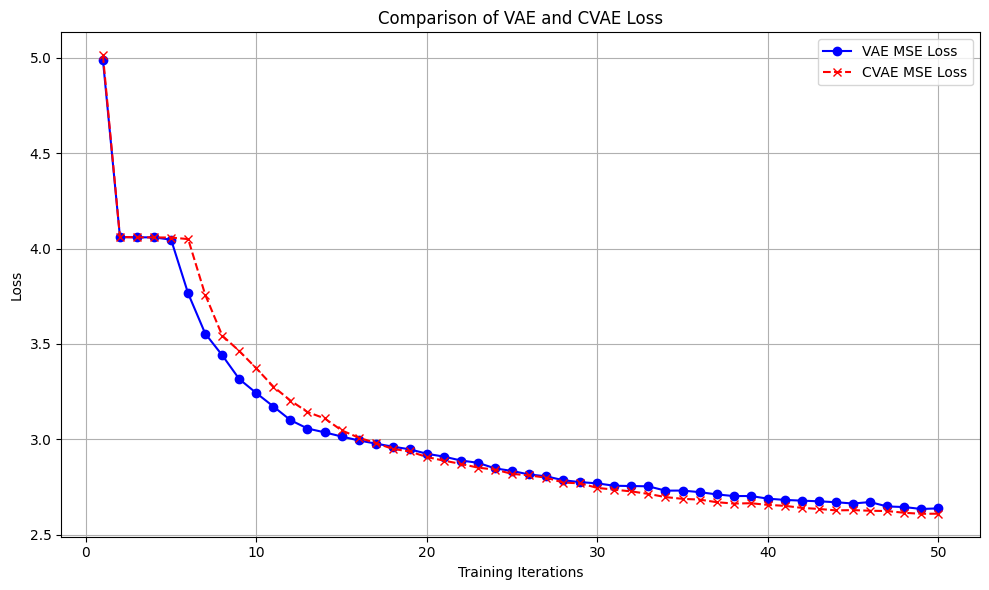

In [10]:
import matplotlib.pyplot as plt

# Assuming you have two lists of loss values: vae_mse_loss and cvae_mse_loss
# You should have these lists populated with the corresponding loss values during training.

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(cvae_MSE_Loss) + 1)

# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, vae_MSE_Loss, label='VAE MSE Loss', marker='o', linestyle='-', color='b')
plt.plot(iterations, cvae_MSE_Loss, label='CVAE MSE Loss', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Comparison of VAE and CVAE Loss')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

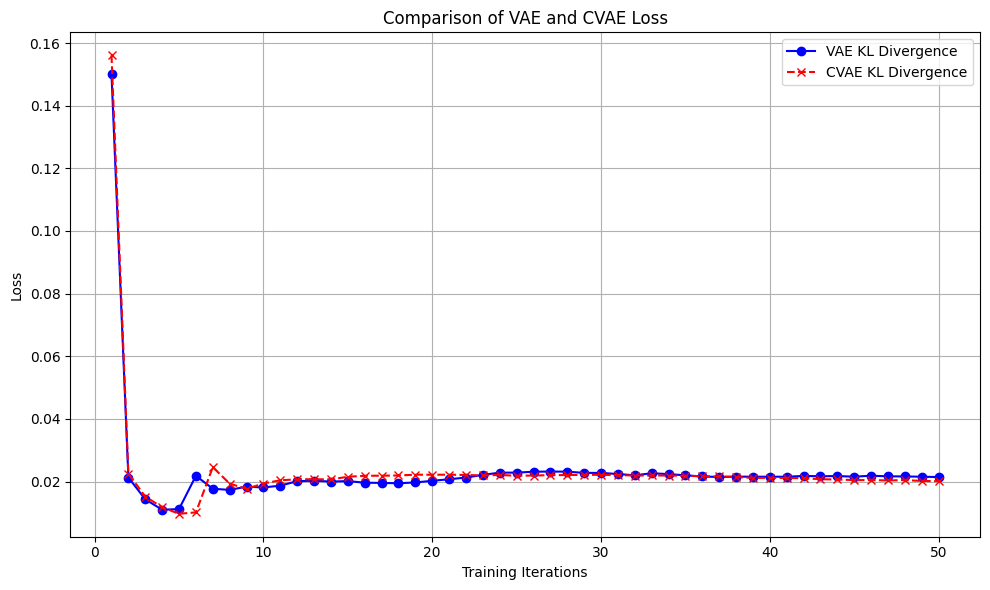

In [11]:
import matplotlib.pyplot as plt

# Assuming you have two lists of loss values: vae_mse_loss and cvae_mse_loss
# You should have these lists populated with the corresponding loss values during training.

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(cvae_KL_Loss) + 1)
cvae_KL_Loss
# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, vae_KL_Loss, label='VAE KL Divergence', marker='o', linestyle='-', color='b')
plt.plot(iterations, cvae_KL_Loss, label='CVAE KL Divergence', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Comparison of VAE and CVAE Loss')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation and Plotting

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

def plot_reconstructed(decode_function, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):

    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])

            x_hat = decode_function(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])

def plot_c_reconstructed(decode_function, c, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):

    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])
            x_hat = decode_function(z,c,i)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])

def imshow(img):
    npimg = img.numpy()
    npimg = np.clip(npimg/255.,0,1) #we need to clip here to avoid bad image values
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Test Data for cVAE

d) Using k=2, plot the latent space, displaying data points at their embedded points. Qualitatively compare this to the latent space produced by the regular VAE, and discuss changes.

Our given label is $[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]$. However, since we are using k=2, cVAE and VAE are both generating not precise images. As you can see from the latent space, it's not that clear what z value stores. For a better performance, we need to increase k dimension.

And I don't see the point of plotting latent space here since we do not know how z values (such as tensor[-2,-2]) were generated. Previously, we matched our c label values to the z value where came from images which represents c label value. However, in this case, we don't know where z values were generated. And I think that's reason why latent spaces below are not clear unlike latent spaces showed in 1.e.

torch.Size([10, 1, 28, 28])


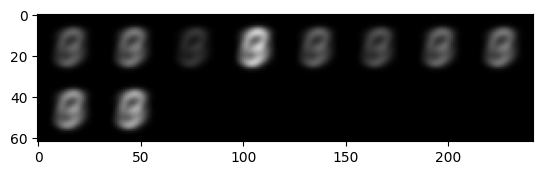

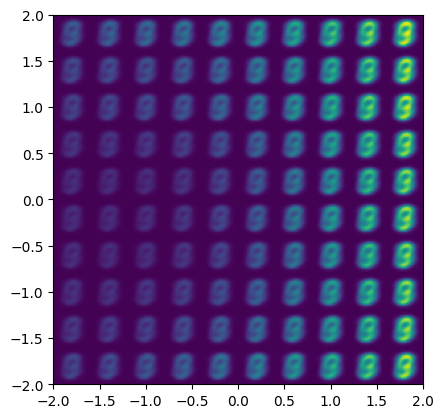

torch.Size([10, 1, 28, 28])


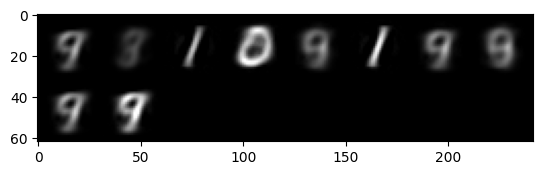

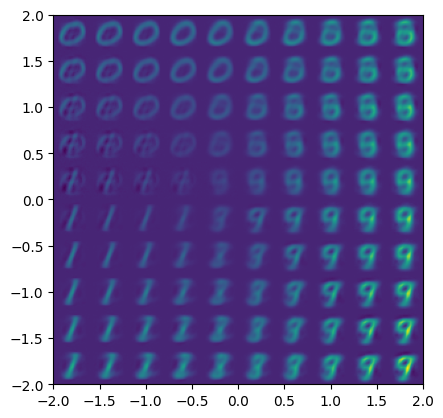

torch.Size([10, 1, 28, 28])


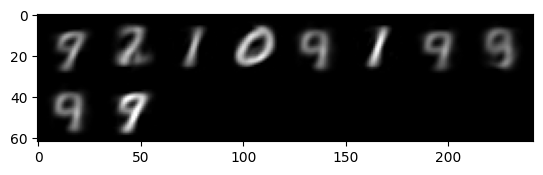

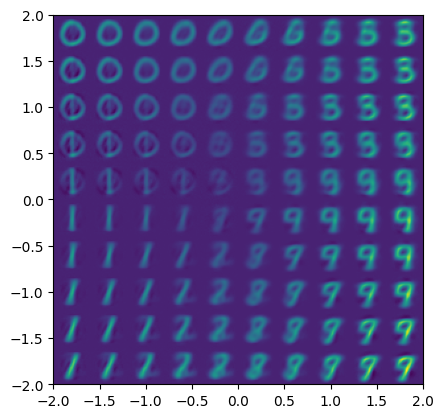

torch.Size([10, 1, 28, 28])


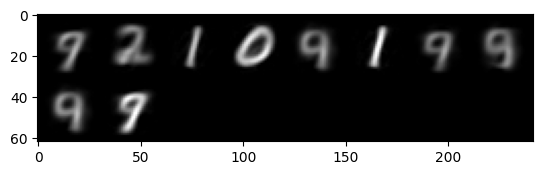

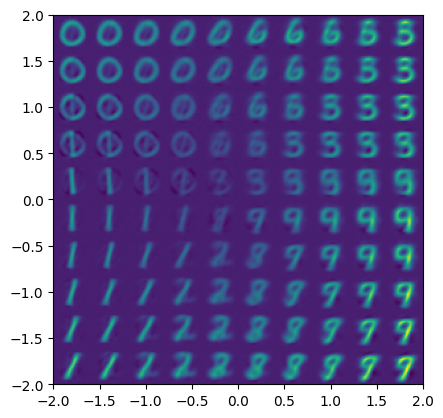

torch.Size([10, 1, 28, 28])


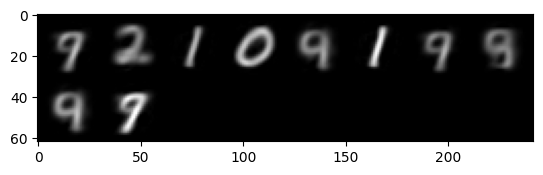

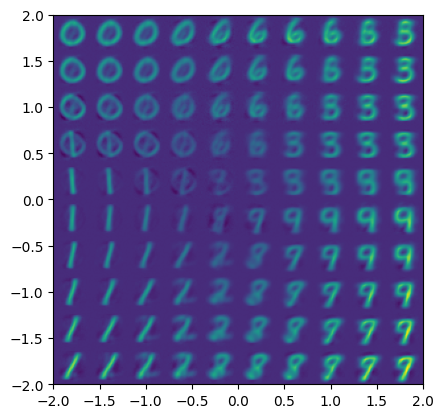

torch.Size([10, 1, 28, 28])


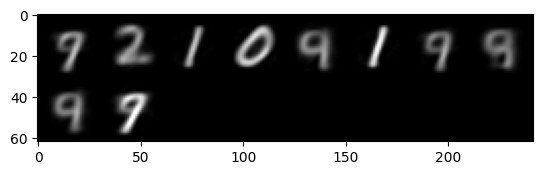

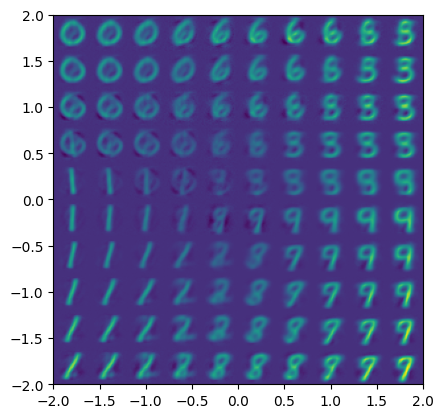

torch.Size([10, 1, 28, 28])


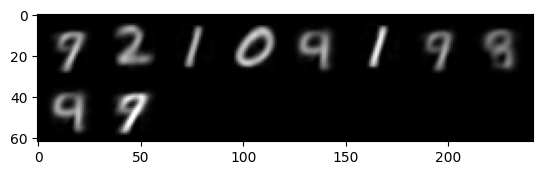

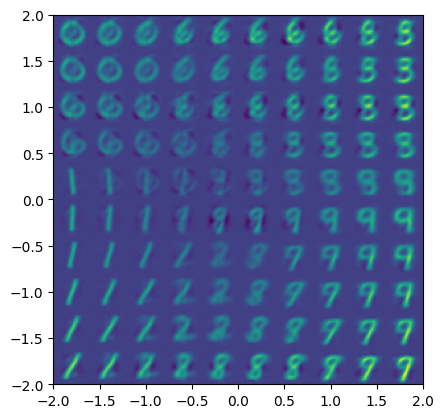

torch.Size([10, 1, 28, 28])


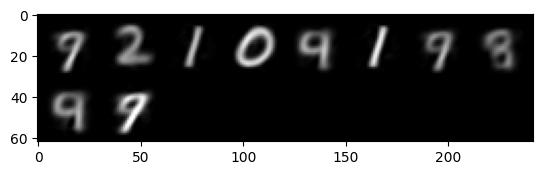

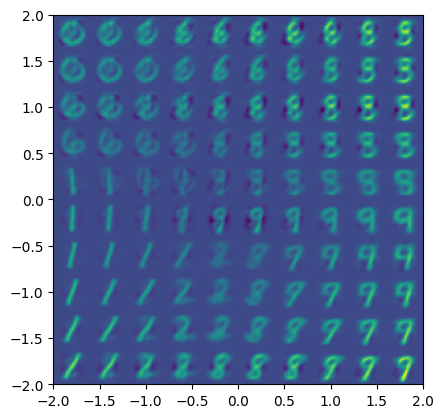

torch.Size([10, 1, 28, 28])


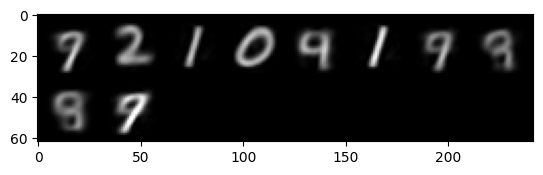

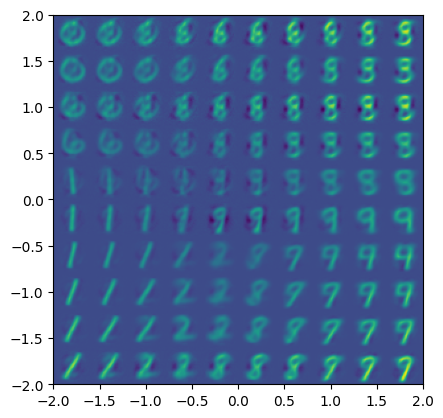

torch.Size([10, 1, 28, 28])


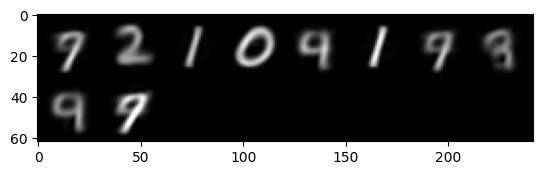

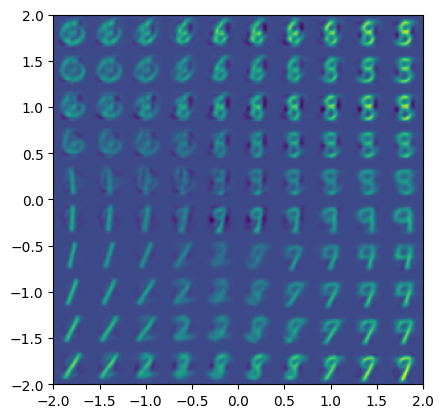

In [13]:
saved_params_path = "./saved_params_cvae"
cvae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

#labels = torch.Tensor([9, 3, 7, 8, 7, 1, 7, 6, 4, 8])
for epoch in range(4,50,5):
    cvae_instance.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))

    images_in = images.view(-1,28**2)

    output,mean_z,log_var_z = cvae_instance.forward(images_in, labels)

    output = output.view(10,1,28,28).clone().detach()
    print(output.shape)
    image_outputs = torchvision.utils.make_grid(output)

    imshow(image_outputs)

    z = mean_z + torch.randn_like(mean_z) * (log_var_z.exp().sqrt())

    plot_c_reconstructed(
        cvae_instance.decode, labels
    )
    plt.show()

# Test Data for VAE

4
torch.Size([10, 1, 28, 28])


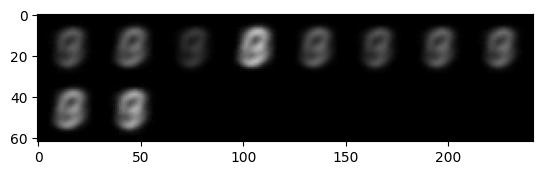

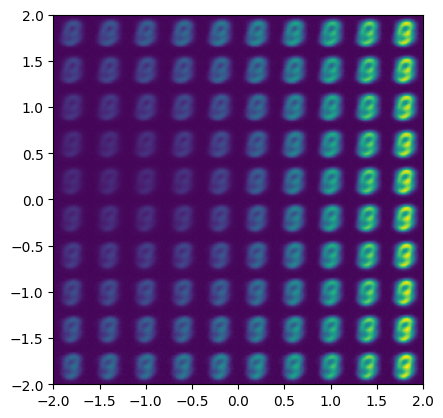

9
torch.Size([10, 1, 28, 28])


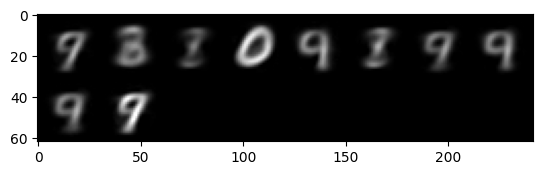

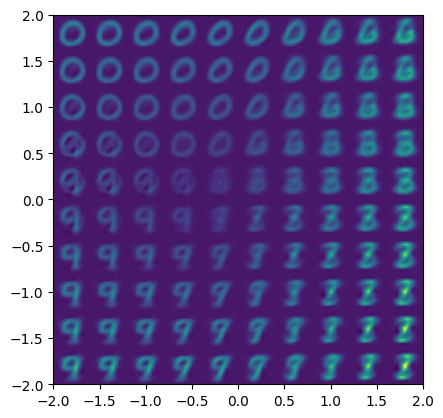

14
torch.Size([10, 1, 28, 28])


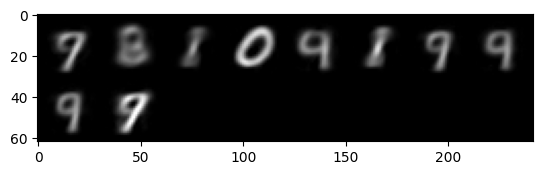

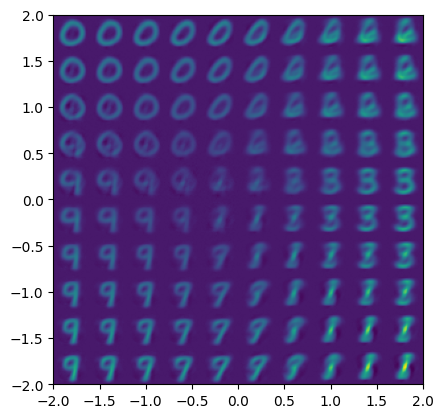

19
torch.Size([10, 1, 28, 28])


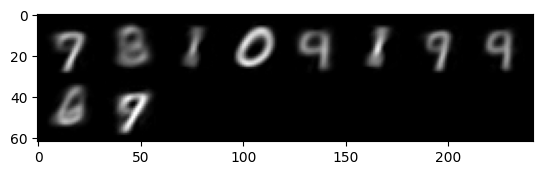

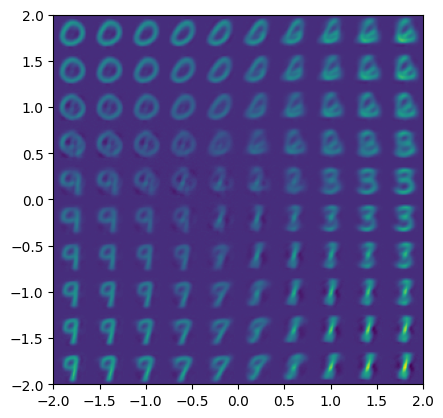

24
torch.Size([10, 1, 28, 28])


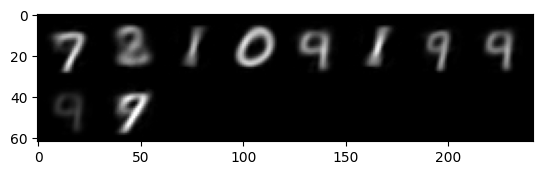

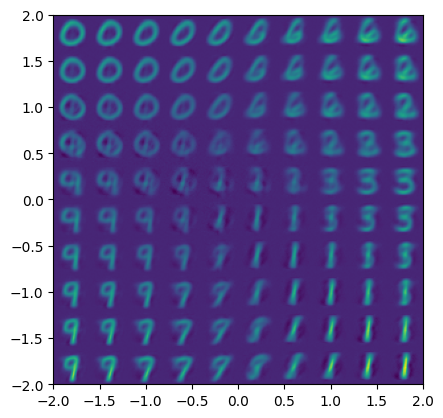

29
torch.Size([10, 1, 28, 28])


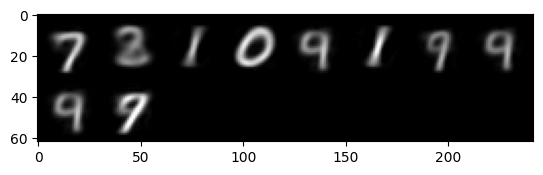

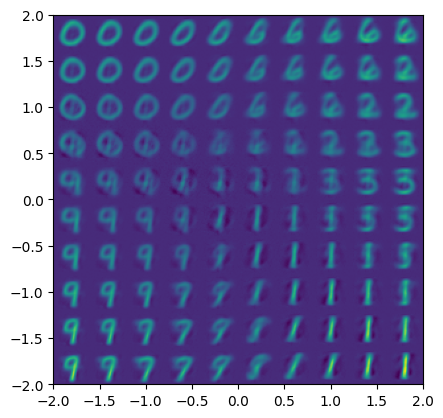

34
torch.Size([10, 1, 28, 28])


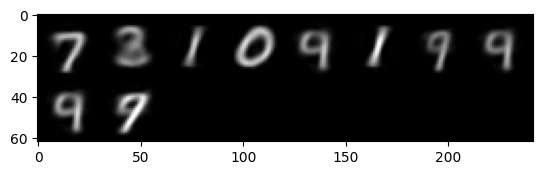

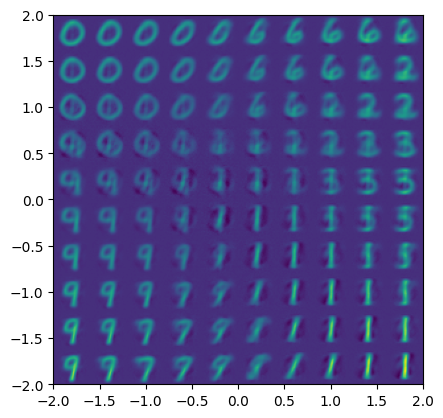

39
torch.Size([10, 1, 28, 28])


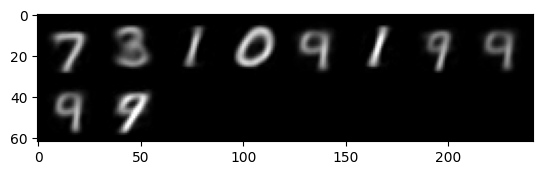

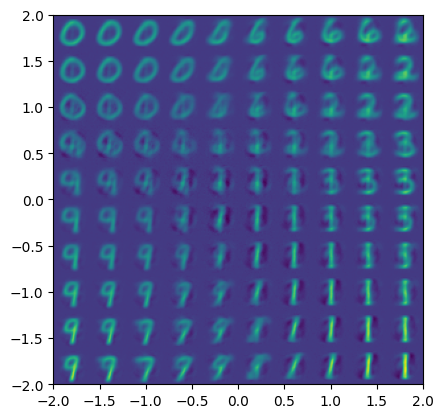

44
torch.Size([10, 1, 28, 28])


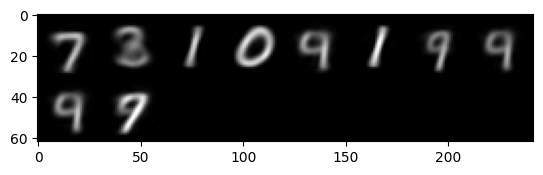

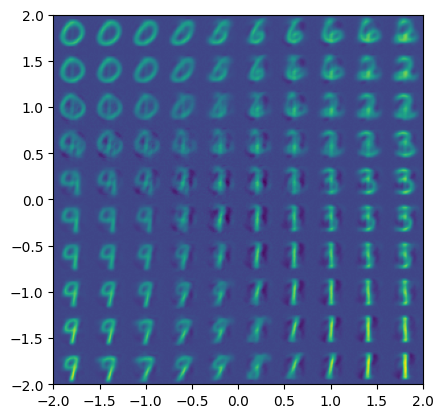

49
torch.Size([10, 1, 28, 28])


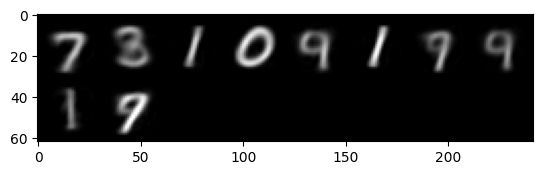

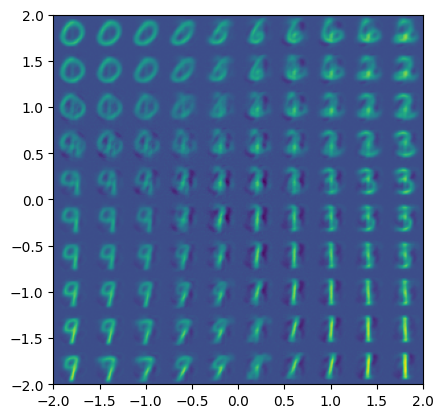

In [14]:
saved_params_path = "./saved_params_vae"
vae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

for epoch in range(4,50,5):
    print(epoch)
    vae_instance.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))

    images_in = images.view(-1,28**2)

    output,mean_z,log_var_z = vae_instance.forward_train(images_in)
    #get z
    #z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())

    output = output.view(10,1,28,28).clone().detach()
    print(output.shape)
    image_outputs = torchvision.utils.make_grid(output)
    imshow(image_outputs)

    plot_reconstructed(
        vae_instance.decode
    )
    plt.show()



e) Manipulate the c variable; using each of the first 10 datapoints in the test dataset as an input, change c to each of the classes and plot the results.

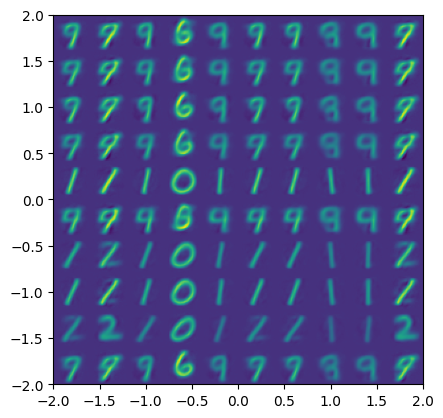

In [56]:
saved_params_path = "./saved_params_cvae"
cvae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

output, mean_z, log_var_z = cvae_instance.forward(images_in, labels)

z = mean_z + torch.randn_like(mean_z) * (log_var_z.exp().sqrt())
ranges=((-2,2),(-2,2))
n_sample_points=10
image_dim=28
img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
    for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
        zval = torch.Tensor([[z[i][0], z[j][1]]])
        x_hat = cvae_instance.decode(zval,labels,i)
        x_hat = x_hat.reshape(28, 28).detach().numpy()
        img[
            (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
            j*image_dim:(j+1)*image_dim] = x_hat

plt.imshow(img, extent=[*ranges[0], *ranges[1]])






#2. Two Step

Consider the standard VAE with pattern

$x \rightarrow_{q(z|x)} z \rightarrow_{p(x|z)} \rightarrow \hat{x}$.

and with Gaussian encoers $q(z|x)$ using deterministic $f_\mu(x)$ and $f_\sigma(x)$, Gaussian priors for z, and deterministic decoder $g(z)$. We can re-index the variables $\{x,z,\hat{x}\}$ to $\{x_0,z_0,x_1\}$, and then extend this pattern: $x_0 \rightarrow_{q(z|x)} z_0 \rightarrow_{p(x|z)} \rightarrow x_1$.

a) Using the VAE, investigate empirically whether $z_0 $ and $z_1$ are similar for real data inputs $x_0$ from MNIST. Support your conclusion with plots/code.

$z_0, z_1$ are not similar for real data inputs $x_0$ yet. To be similar, we need much more training. 1 training is not enough to be similar with given input. And also, we are using 2 dimension z which is not sufficient to absorb sufficient information from input.



torch.Size([10, 1, 28, 28])


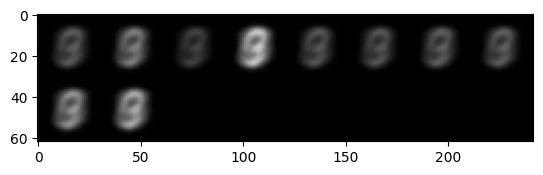

torch.Size([10, 1, 28, 28])


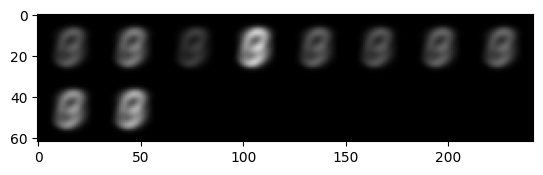

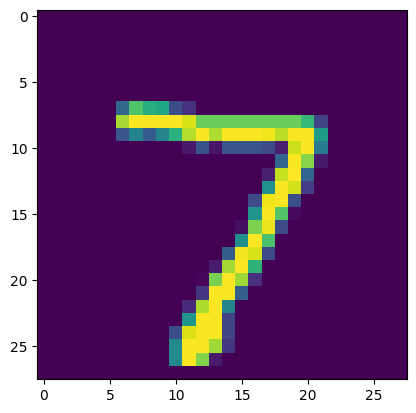

In [36]:

# z_0 -> x_1(How close x1 to x0?)
saved_params_path = "./saved_params_vae"
vae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

vae_instance.load_state_dict(torch.load(f"{saved_params_path}/{0}.pth"))

images_in = images.view(-1,28**2)

output,mean_z,log_var_z = vae_instance.forward_train(images_in)

output = output.view(10,1,28,28).clone().detach()
print(output.shape)
image_outputs = torchvision.utils.make_grid(output)

imshow(image_outputs)


# z_1 -> x_2 (How close x2 is x0?)
vae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

vae_instance.load_state_dict(torch.load(f"{saved_params_path}/{1}.pth"))

images_in = images.view(-1,28**2)

output,mean_z,log_var_z = vae_instance.forward_train(images_in)

output = output.view(10,1,28,28).clone().detach()
print(output.shape)
image_outputs = torchvision.utils.make_grid(output)

imshow(image_outputs)

imshow(images[0])





b) Describe the distribution $q(z_0,z_1|x_0);$ is it Gaussian? Why or why not?

- 1. $P(z_0,z_1|x_0) = P(z_0|x_0)P(z_1|z_0,x_0)$.

- 2. We definitely know $P(z_0|x_0)$ is Gaussian, then if $P(z_1|z_0,x_0)$ is also Gaussian, $q(z_0,z_1|x_0)$ is Gaussian.

- 3. $P(z_1|z_0,x_0) = P(z_1|z_0)$ by using conditional independence. We can use conditional independence by looking at structure of our VAE $(x_0 \rightarrow z_0 \rightarrow x_1 \rightarrow z_1).$ Since $z_0$ and $z_1$ are caused from $x_0$, we can think $P(z_1|z_0,x_1)$ is conditionally independent.

- 4. Then, $P(z_1|z_0)$ is definitely also a Gaussian since our decoder is deterministic.

- 5. Therefore, $q(z_0,z_1|x_0)$ is a Gaussian.

c) Is regularizing $q(z_0,z_1|x_0)$ in the same way as we regularized $q(z_0|x_0)$, reasonable for making $z_0$ and $z_1$ similar?
- We know that $q(z_0,z_1|x_0) = q(z_0|x_0)q(z_1|z_0)$ from 2.b. Then, our regularizer will be $KL[q(z_0|x_0)q(z_1|z_0)||p(x_0)] = KL[q(z_0|x_0)q(z_1|z_0)||N(0,I)]$. Then, our regularizer will try to make $q(z_0|x_0)q(z_1|z_0)$ closer to $N(0,I)$ which will reasonably try to make $z_0$ and $z_1$ similar.


d) Suppose instead we added a regularization term $||z_0 - z_1||^2_2$ to the loss function. What are we intuitively asking of our model? Is there an associated probability model with this ask?
- $||z_0 - z_1||^2_2$ is a L-2 norm which measures distance from $z_0$ to $z_1$. By adding a regularization term $||z_0 - z_1||^2_2$, we are intuitively asking how close (similar) $z_0$ and $z_1$ to our model and given regularization term will promote smoother latent space. Generative Adversarial Network also ask this question since GAN tries to manipulate latent space to generate closer (similar) output.

e) Provide another regularization option besides the term introduced in part d), and argue for its correctness as a good regularization term.

Instead of $||z_0 - z_1||^2_2$, I think KL Divergence is much better since we're trying to find best latent variable which is not close to previous latent variable but given input. Hence, I believe original VAE with KL Divergence $KL[q(z_i|x_i)|N(0,I)]$ will generate higher performance.


# 3 Causing Collapses and Overfits

a) Describe qualitatively the posterior collapse phenomenon and why it's a problem

- Posterior collapse phenomenon refers to a situation where KL term is too strong, and so the encoder $q(z|x)$ collapses to the prior $p(z). As a result, decoder only receives insufficient information about input from latent variable. It leads decoder to loose diverse information about input.

b) Describe ways to diagnose posterior collapse
- It can be diagnosed by extremely low KL error terms, and low variance reconstruction.

c) Explain a possible cause for your instructors' particular posterior collapse, explaining how the modification to the code induces such a collapse
- Transform should be fixed. Since given input type is an image, it needs one more code to normalize [0,1] to [0,256] as the pixel values range from 0~256.

d) Another error mode of the VAE is overfitting. Describe the overfit phenomena in the context of auto-encoder

- Overfitting in Auto-encoder is essentially memorization. When MSE term is too strong compared to the KL error terms, overfitting can be diagnosed. Overfit phenomena occured when we train small datasets with expensive network in too long time.


e) Is it possible to both overfit and have posterior collapse?
- It is possible to have both overfitting and posterior collapse. Posterior collapse happens when latent dimension is too small to absorb sufficient information from input which lead decoder to produce output with insufficient information about input. And overfitting happens when we train small datasets with expensive network in too long time. Hence, if we set latent dimension to be small and train small datasets with expensive network in long time, it will trigger our model to have both overfit and posterior collapse problem.
